In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

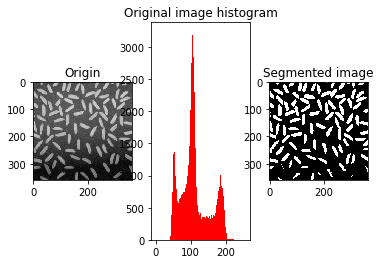

In [6]:
# https://blog.csdn.net/qq_44111805/article/details/126447143
#全局阈值分割
# 读取图像
I = cv2.imread("rice.png", cv2.IMREAD_GRAYSCALE)  # flags=0 读取为灰度图像

# 获取图像尺寸
width, height = I.shape

# 创建空白图像
K = np.zeros((width, height), dtype=np.uint8)

# 设定全局阈值
threshold = 130

# 使用全局阈值对图像进行分割
for i in range(width):
    for j in range(height):
        if I[i, j] > threshold:
            K[i, j] = 255  # 将大于全局阈值的像素点置为255(白色)
        else:
            K[i, j] = 0    # 将小于等于全局阈值的像素点置为0(黑色)

# 显示原始图像、原始图像直方图和分割后的图像
plt.subplot(131), plt.imshow(I, cmap='gray'),plt.title('Origin')
plt.subplot(132), plt.hist(I.flatten(), bins=256, range=(0, 256), color='r')
plt.title('Original image histogram')
plt.subplot(133), plt.imshow(K, cmap='gray')
plt.title('Segmented image')
plt.show()

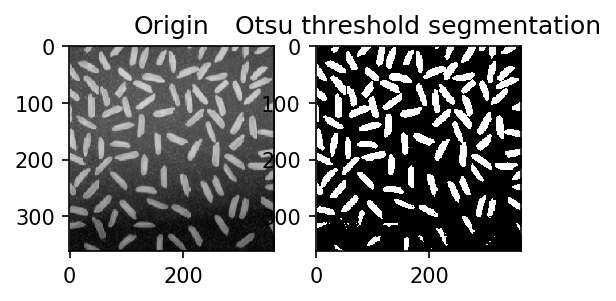

In [41]:
# Otsu阈值分割
# 读取图像
I = cv2.imread('rice.png', cv2.IMREAD_GRAYSCALE)
# 将图像转换为8位无符号整数类型
I = cv2.convertScaleAbs(I)


# 使用 Otsu 算法进行图像分割
_, J = cv2.threshold(I, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(dpi=150) #指定输出像素大小
# 显示原始图像和分割后的图像
plt.subplot(131), plt.imshow(I, cmap='gray')
plt.title('Origin')

plt.subplot(132), plt.imshow(J, cmap='gray')
plt.title('Otsu threshold segmentation')

plt.show()

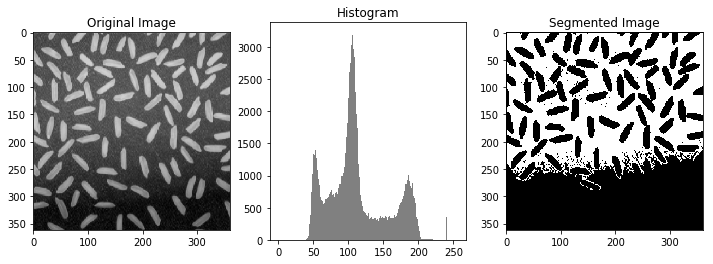

In [29]:
# 基于区域的图像分割
# https://blog.csdn.net/qq_46041930/article/details/134963616

# 定义区域生长分割算法
def region_growing(img, seed, threshold):
    # 将图像全部设置为黑
    result = np.zeros_like(img, dtype=np.uint8)
    
    # 设置种子点范围条件
    if seed[0] < 0 or seed[1] < 0 or seed[1] > img.shape[0] - 1 or seed[0] > img.shape[1] - 1:
        return None
    
    # 种子点集
    seeds = [seed]
    # 种子点设置为白
    result[seed[1], seed[0]] = 255
    
    # 8连接生长方向
    grow_directions = [(-1, -1), (0, -1), (1, -1), (-1, 0), (1, 0), (-1, 1), (0, 1), (1, 1)]
 
    # 开始生长
    while seeds:
        # 取出一个种子点作为现在循环的初始种子点
        seed_current = seeds.pop()
        
        # 遍历各生长方向的邻点
        for direction in grow_directions:
            neighbor_point = (seed_current[0] + direction[0], seed_current[1] + direction[1])
            
            # 邻点超出范围
            if (neighbor_point[0] < 0 or neighbor_point[1] < 0 or
                neighbor_point[0] >= img.shape[1] or neighbor_point[1] >= img.shape[0]):
                continue
            
            if (result[neighbor_point[1], neighbor_point[0]] == 0 and
                abs(int(img[neighbor_point[1], neighbor_point[0]]) - int(img[seed[1], seed[0]])) < threshold):
                # 设置为种子点
                result[neighbor_point[1], neighbor_point[0]] = 255
                seeds.append(neighbor_point)  # 压入种子集
    
    return result

# 读取图像
img = cv2.imread('rice.png', cv2.IMREAD_GRAYSCALE)
# 获取图像尺寸
width, height = img.shape
# 定义种子点和阈值
# seed = (50,50) 
seed = (int((height+1)/2), int((width+1)/2))  # 作为示例，你需要根据具体情况调整种子点的位置
threshold = 20   # 作为示例，你需要根据具体情况调整阈值

# 调用区域生长分割函数
result = region_growing(img, seed, threshold)

# 显示结果
plt.figure(figsize=(12, 4))

# 显示原始图像
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# 显示原始图像的灰度直方图
plt.subplot(132)
plt.hist(img.ravel(), 256, [0, 256], color='gray')
plt.title('Histogram')

# 显示分割后的图片
plt.subplot(133)
plt.imshow(result, cmap='gray')
plt.title('Segmented Image')

plt.show()


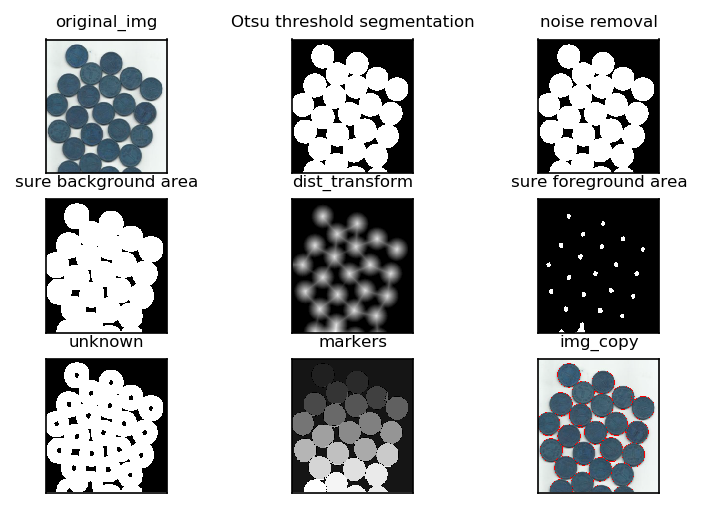

In [38]:
# 分水岭分割
# https://blog.csdn.net/qq_43456016/article/details/129673742?ops_request_misc=&request_id=&biz_id=102&utm_term=%E5%88%86%E6%B0%B4%E5%B2%AD%E7%AE%97%E6%B3%95%E5%88%86%E5%89%B2%E5%9B%BE%E5%83%8F&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-0-129673742.nonecase&spm=1018.2226.3001.4187
# 1.获取硬币的近似估计
img = cv2.imread('coins.png')
assert img is not None, "file could not be read, check with os.path.exists()"
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# 创建原始图像的副本
img_copy = img.copy()

# 实现图像标注以及修复处理
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img_copy,markers)
# The boundary region will be marked with -1.
img_copy[markers == -1] = [255,0,0]

titles = ['original_img', 'Otsu threshold segmentation', 'noise removal',
          'sure background area','dist_transform','sure foreground area',
          'unknown','markers','result']
images = [img,thresh,opening,sure_bg,dist_transform,sure_fg,unknown,markers,img_copy]
rows = 3
cols = 3
plt.figure(dpi=150) #指定输出像素大小
# 显示处理后的图像
for i in range(len(images)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i],cmap='gray')
    plt.title(titles[i], fontsize=8)
    plt.xticks([]), plt.yticks([])
plt.show()

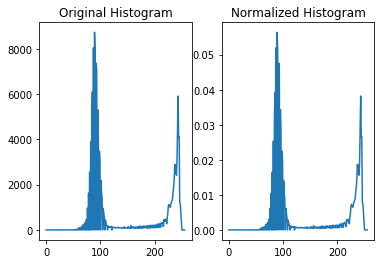

In [42]:
# 读取灰度图像
img = cv2.imread('coins.png', cv2.IMREAD_GRAYSCALE)

# 计算直方图
hist, bins = np.histogram(img.ravel(), 256, [0,256])

# 归一化直方图
normalized_hist = hist / np.sum(hist)

# 绘制原始直方图
plt.subplot(1, 2, 1)
plt.plot(hist)
plt.title('Original Histogram')

# 绘制归一化后的直方图
plt.subplot(1, 2, 2)
plt.plot(normalized_hist)
plt.title('Normalized Histogram')

plt.show()